In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
from statsmodels import regression

import sktime
import pmdarima

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import plot_tree

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

##### Using Pandas, we load the .csv file and save it as a variable.

In [2]:
gas_df = pd.read_csv('US_Retail_Gasoline_Prices.csv')

In [3]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 2 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   Date                                                                          343 non-null    object 
 1   U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)  343 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.5+ KB


That's quite a long column name. Let's rename it in case we need to refer to it. Good to see there are no nulls here. We also need to move the date column into a date category AND move it into our index to start our analysis.

In [4]:
gas_df.describe()

,U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)
count,343.000000
mean,2.232283
std,0.881882
min,0.962000
25%,1.326500
50%,2.285000
75%,2.890500
max,4.114000


Wow! The most expensive gas has ever been was `$4.11`. Cheapest was `$0.96`. Don't you wish we could pay less than a dollar for a gallon of gas? (Or just not use gas at all.)

In [5]:
gas_df.head()

,Date,U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)
0,04/15/1993,1.078
1,05/15/1993,1.100
2,06/15/1993,1.097
3,07/15/1993,1.078
4,08/15/1993,1.062


##### Let's change the column name first.

In [6]:
gas_df = gas_df.rename(columns = {'U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)': 'gas_price'})

In [7]:
gas_df.head()

,Date,gas_price
0,04/15/1993,1.078
1,05/15/1993,1.100
2,06/15/1993,1.097
3,07/15/1993,1.078
4,08/15/1993,1.062


##### Now to change the column names to all lowercase

In [8]:
gas_df.columns = gas_df.columns.str.lower()

##### Cool! Now let's change the date type to datetime

In [9]:
gas_df['date'] = pd.to_datetime(gas_df['date'])

In [10]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       343 non-null    datetime64[ns]
 1   gas_price  343 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.5 KB


In [11]:
gas_df.head()

,date,gas_price
0,1993-04-15,1.078
1,1993-05-15,1.100
2,1993-06-15,1.097
3,1993-07-15,1.078
4,1993-08-15,1.062


Perfect. Now we move the changed date into our index.

In [12]:
gas_df.set_index('date', inplace=True, drop = True)

In [13]:
gas_df.head()

,gas_price
date,
1993-04-15,1.078
1993-05-15,1.100
1993-06-15,1.097
1993-07-15,1.078
1993-08-15,1.062


### Need to add this because we will get an error otherwise.

In [27]:
gas_df.index = pd.DatetimeIndex(gas_df.index, freq = gas_df.index.inferred_freq)

In [28]:
gas_df

,gas_price
date,
1993-04-15,1.078
1993-05-15,1.100
1993-06-15,1.097
1993-07-15,1.078
1993-08-15,1.062
...,...
2021-06-15,3.157
2021-07-15,3.231
2021-08-15,3.255


### Let's try plotting this first.
What does it look like?

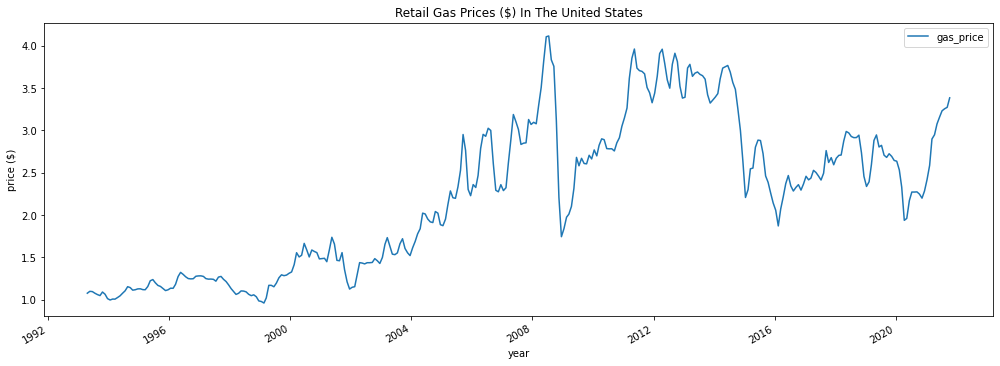

In [16]:
gas_df.plot(figsize=(17,6),
           xlabel = 'year',
           ylabel = 'price ($)',
           title = 'Retail Gas Prices ($) In The United States');

Okay, so a few things here: 

1. Retail gas prices seem to have increased exponentially after September 11. The Iraq War certainly did not help retail gas prices. 
2. There was a giant drop in price after the housing bust in 2008. The price, however, rebounded in 2011 and seems to have stayed mostly consistent until it dropped sometime in 2015.
3. After the Trump administration, retail gas prices are soaring yet again. So what does this indicate? 

Now I'm wondering if it is even possible to predict the price of retail gas given these external factors. 
- Is there seasonality that we can depend on?
- What will the charts show? 

#### Train, test, split here.

###### Have to resample

In [44]:
y = gas_df['gas_price'].resample('M').sum()

In [45]:
y_train, y_test = temporal_train_test_split(y)

In [46]:
y_train

date
1993-04-30    1.078
1993-05-31    1.100
1993-06-30    1.097
1993-07-31    1.078
1993-08-31    1.062
              ...  
2014-04-30    3.735
2014-05-31    3.750
2014-06-30    3.766
2014-07-31    3.688
2014-08-31    3.565
Freq: M, Name: gas_price, Length: 257, dtype: float64

In [47]:
y_test

date
2014-09-30    3.484
2014-10-31    3.255
2014-11-30    2.997
2014-12-31    2.632
2015-01-31    2.208
              ...  
2021-06-30    3.157
2021-07-31    3.231
2021-08-31    3.255
2021-09-30    3.272
2021-10-31    3.384
Freq: M, Name: gas_price, Length: 86, dtype: float64

#### Let's try a Naive Forecast.

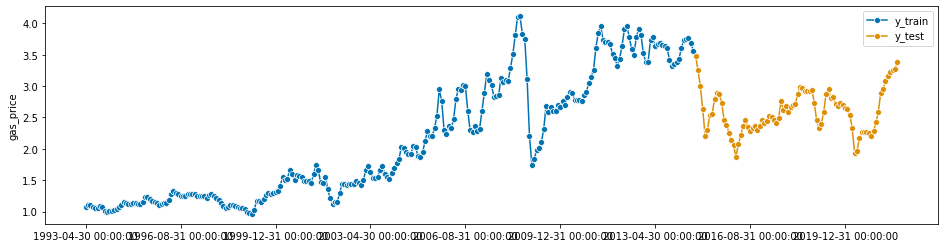

In [48]:
plot_series(y_train, y_test, labels = ['y_train','y_test']);

In [49]:
naive_model_last = NaiveForecaster(strategy = 'last')
naive_model_last

NaiveForecaster()

In [50]:
naive_model_last.fit(y_train)

NaiveForecaster()

In [51]:
y_last_preds = naive_model_last.predict(list(range(1,len(y_test)+1)))

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


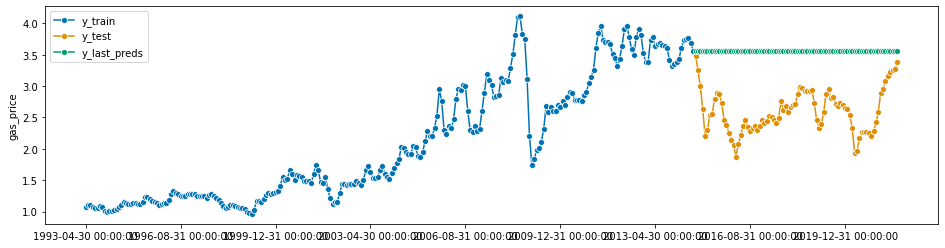

In [52]:
plot_series(y_train, y_test, y_last_preds, labels = ['y_train', 'y_test', 'y_last_preds']);

In [57]:
round(mse(y_test, y_last_preds, squared = False),2)

1.03

Means we're about a dollar off.

#### Checking out Baseline Mean Forecast

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


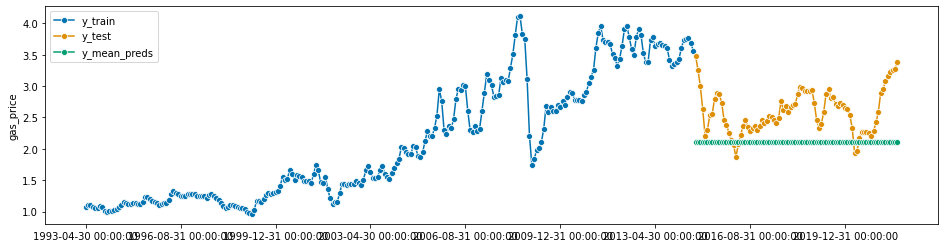

In [58]:
naive_model_mean = NaiveForecaster(strategy = 'mean')
naive_model_mean.fit(y_train)
y_mean_preds = naive_model_mean.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_mean_preds, labels = ['y_train', 'y_test', 'y_mean_preds']);

In [60]:
round(mse(y_test, y_mean_preds, squared = False), 2)

0.59

This is much better than our previous prediction — much closer to zero. This is telling us that our predictions are `$0.59` off each predicted value.

#### Okay, let's check for seasonality.

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


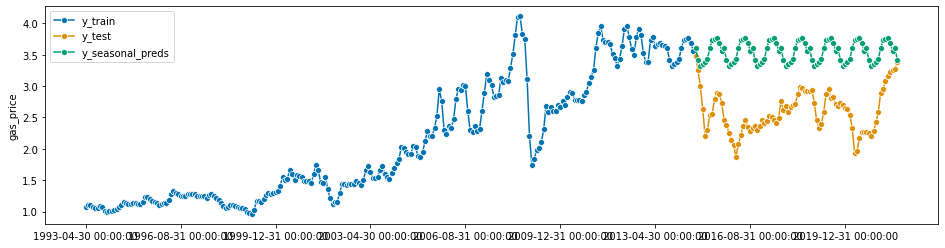

In [68]:
naive_model_seasonal = NaiveForecaster(strategy = 'last', sp = 12)
naive_model_seasonal.fit(y_train)
y_seasonal_preds = naive_model_seasonal.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_seasonal_preds, labels = ['y_train', 'y_test', 'y_seasonal_preds']);

In [69]:
round(mse(y_test, y_seasonal_preds, squared = False),2)

1.02

Naive seasonal forecast performed worse than our baseline mean. This is not what we want!

#### Can our SARIMA model fix this?

In [70]:
sarima_model = AutoARIMA(sp = 12, trace= True)
sarima_model.fit(y_train)

Performing stepwise search to minimize aic


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-363.091, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-275.600, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-337.005, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-348.285, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-276.373, Time=0.04 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-363.830, Time=0.60 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-367.156, Time=0.31 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-363.583, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-359.051, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-356.358, Time=0.16 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-355.708, Time=0.35 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-369.540, Time=0.36 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,3)(1,0,0)[12] intercept   : AIC=-366.769, Time=0.87 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-366.852, Time=0.95 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,3)(1,0,1)[12] intercept   : AIC=-364.182, Time=1.24 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-370.460, Time=0.33 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

 ARIMA(1,1,3)(1,0,0)[12] intercept   : AIC=-368.565, Time=0.80 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,3)(0,0,1)[12] intercept   : AIC=-368.458, Time=0.81 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,3)(1,0,1)[12] intercept   : AIC=-366.580, Time=0.89 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=-359.912, Time=0.25 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,4)(0,0,0)[12] intercept   : AIC=-368.806, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-356.190, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[12] intercept   : AIC=-358.235, Time=0.17 sec


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,4)(0,0,0)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[12]             : AIC=-367.042, Time=0.22 sec

Best model:  ARIMA(1,1,3)(0,0,0)[12] intercept
Total fit time: 11.326 seconds


AutoARIMA(sp=12, trace=True)

/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/time/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


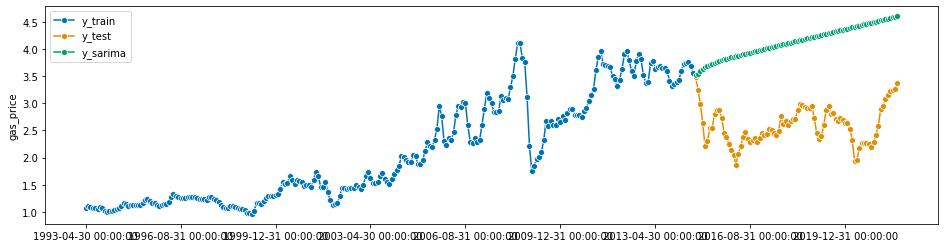

In [72]:
y_sarima = sarima_model.predict(list(range(1, len(y_test) +1)))
plot_series(y_train, y_test, y_sarima, labels = ['y_train', 'y_test', 'y_sarima']);

In [74]:
round(mse(y_test, y_sarima, squared = False),2)

1.6

This is even worse!

#### Trying H-W

In [100]:
hw = ExponentialSmoothing(
    y_train,
    seasonal_periods = 12,
    trend = 'mul',
    seasonal = 'add').fit()

/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [101]:
hw.summary()

Dep. Variable:,gas_price,No. Observations:,257
Model:,ExponentialSmoothing,SSE,4.137
Optimized:,True,AIC,-1029.175
Trend:,Multiplicative,BIC,-972.390
Seasonal:,Additive,AICC,-1026.301
Seasonal Periods:,12,Date:,"Wed, 27 Oct 2021"
Box-Cox:,False,Time:,10:16:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


/opt/anaconda3/envs/time/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


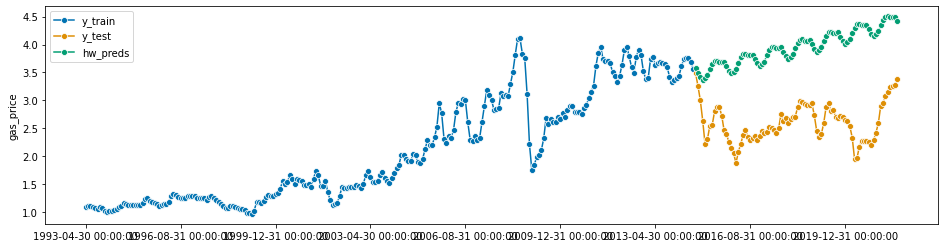

In [102]:
hw_preds = hw.forecast(len(y_test))
plot_series(y_train, y_test, hw_preds, labels = ['y_train', 'y_test', 'hw_preds']);

In [91]:
round(mse(y_test, hw_preds, squared = False),2)

1.41

Much better than what we got with SARIMA, but still really bad.

#### Plotting decompose data.

In [96]:
y_df = pd.DataFrame(y)
y_df.index = pd.to_datetime(y_df.index)

In [110]:
pd.PeriodIndex(y_df.index)

PeriodIndex(['1993-04', '1993-05', '1993-06', '1993-07', '1993-08', '1993-09',
             '1993-10', '1993-11', '1993-12', '1994-01',
             ...
             '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
             '2021-07', '2021-08', '2021-09', '2021-10'],
            dtype='period[M]', name='date', length=343)

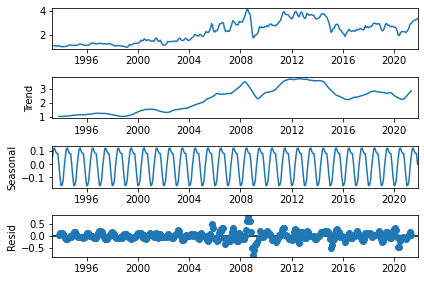

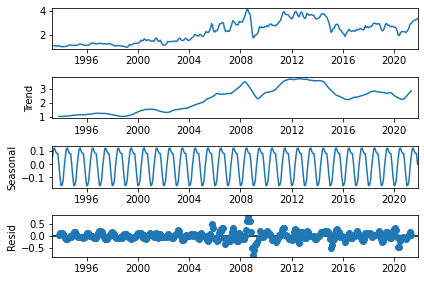

In [97]:
seasonal_decompose(y_df, period = 12).plot()

#### Trying AutoETS

In [103]:
hw_model = AutoETS(auto = True,
                  sp = 12)

hw_model.fit(y_train)

AutoETS(auto=True, sp=12)

In [104]:
hw_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:              gas_price   No. Observations:                  257
Model:                       ETS(MNM)   Log Likelihood                 242.361
Date:                Wed, 27 Oct 2021   AIC                           -452.721
Time:                        10:17:06   BIC                           -395.936
Sample:                    04-30-1993   HQIC                          -429.885
                         - 08-31-2014   Scale                            0.002
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.097     10.354      0.000       0.811       1.189
smoothing_seasonal   6.647e-05      0.085      0.001      0.999      -0.166       0.167
initial_level           1.0753     65.502      0.016      0.987    -127.306     129.456
initial_seasonal.0      0.9614     58.561      0.016      0.987    -113.816     115.739
initial_seasonal.1      0.9243     56.299      0.016      0.987    -109.420     111.269
initial_seasonal.2      0.9107     55.472      0.016      0.987    -107.812     109.633
initial_seasonal.3      0.9045     55.095      0.016      0.987    -107.081     108.890
initial_seasonal.4      0.9353     56.973      0.016      0.987    -110.729     112.600
initial_seasonal.5      0.9678     58.950      0.016      0.987    -114.573     116.508
initial_seasonal.6      1.0001     60.920      0.016      0.987    -118.401     120.401
initial_seasonal.7      0.9991     60.860      0.016      0.987    -118.284     120.282
initial_seasonal.8      1.0023     61.054      0.016      0.987    -118.661     120.665
initial_seasonal.9      1.0201     62.139      0.016      0.987    -120.770     122.810
initial_seasonal.10     1.0219     62.250      0.016      0.987    -120.985     123.029
initial_seasonal.11     1.0000     60.913      0.016      0.987    -118.386     120.386
===================================================================================
Ljung-Box (Q):                       98.66   Jarque-Bera (JB):               230.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [117]:
y_test.index = pd.to_datetime(y_test.index, infer_datetime_format = True)

<AxesSubplot:xlabel='date'>

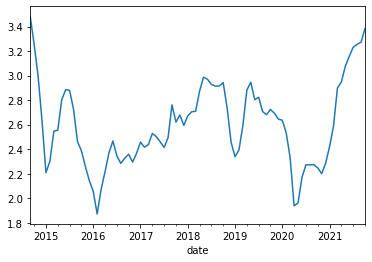

In [120]:
y_test.plot()

### Could the predictions be better if we 